In [2]:
# Dynamicky pridaj src/ do sys.path, nech fungujú importy z vlastných modulov
import sys
import os

# Absolútna cesta k tomuto notebooku
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))

# Cesta k src/ priečinku, ktorý je o úroveň vyššie
SRC_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", "src"))
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, PROJECT_ROOT.as_posix())

In [3]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support
) 
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from src.data.dataset_loader import DatasetLoader
from src.data.datasets import DomainDataset, RDAPDataset, DNSDataset, GEODataset

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/home/fetagpu/miniconda3/envs/gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Domain names

## DGA

In [ ]:
# 2. Config
DATA_CSV = "../../datasets/dga/dga_preprocessed.csv"
CHECKPOINT = "../models/domain/BEST_dga_prajjwal1-bert-medium_20250503_145342.pt" 
PRETRAINED = "prajjwal1/bert-medium"
SPLITS_NPZ = "splits.npz"
MAX_LENGTH = 32
BATCH_SIZE = 512
RANDOM_STATE = 42 
NUM_LABELS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Subset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)

df = pd.read_csv(DATA_CSV, usecols=["domain_name", "label"])  # or however your loader works
domains = df["domain_name"]
labels  = df["label"]

splits = np.load(SPLITS_NPZ)
train_idx = splits["train"]
val_idx   = splits["val"]
test_idx  = splits["test"]

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)
full_dataset = DomainDataset(   
    df,                         
    tokenizer,                  
    MAX_LENGTH                  
)

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
test_ds  = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)
state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels_batch   = batch["label"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits  = outputs.logits

        # hard predictions
        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels_batch.cpu().tolist())

        # soft probabilities for ROC-AUC
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())

# Compute your metrics
acc  = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)
fpr, tpr, _   = roc_curve(all_labels, all_probs)
roc_auc_score = roc_auc_score(all_labels, all_probs)

print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")
print(f"roc_auc:   {roc_auc_score:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


accuracy:  0.9853
precision: 0.9836
recall:    0.9871
f1-score:  0.9854
roc_auc:   0.9988


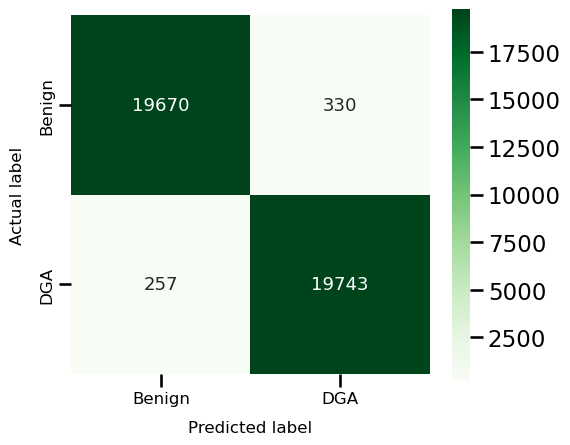

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Benign", "DGA"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)  

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,       
    linecolor="white",  
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7,   
        "pad": 0.05,     
        "fraction": 0.15 
    },
    annot_kws={"size": 13},

)  

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)              
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9988
AUC via roc_auc_score:           0.9988


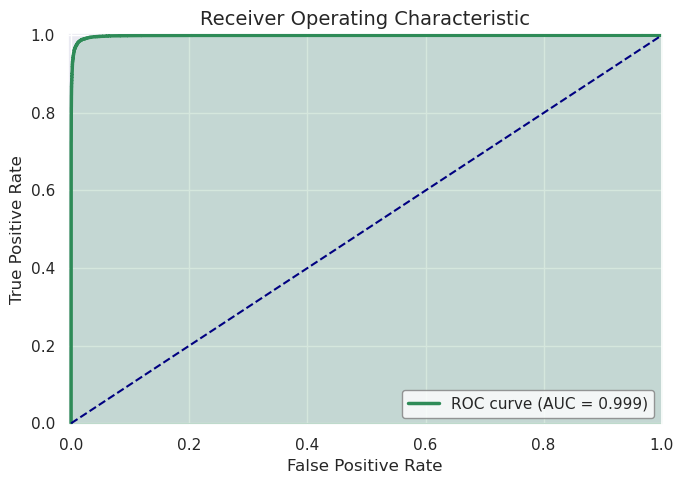

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        # label="Chance"
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


## Malware

In [ ]:
DATA_CSV       = "../../datasets/malware/malware_preprocessed.csv"
CHECKPOINT     = "../models/domain/BEST_malware_google-electra-base-discriminator_20250504_001819.pt" 
PRETRAINED     = "google/electra-base-discriminator"
SPLITS_NPZ = "splits.npz"
MAX_LENGTH     = 32
BATCH_SIZE     = 128
RANDOM_STATE   = 42
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Subset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)

df = pd.read_csv(DATA_CSV, usecols=["domain_name", "label"])  # or however your loader works
domains = df["domain_name"]
labels  = df["label"]

splits = np.load(SPLITS_NPZ)
train_idx = splits["train"]
val_idx   = splits["val"]
test_idx  = splits["test"]

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)
full_dataset = DomainDataset(  
    df,                        
    tokenizer,                 
    MAX_LENGTH                 
)

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
test_ds  = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)
state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels_batch   = batch["label"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits  = outputs.logits

        # hard predictions
        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels_batch.cpu().tolist())

        # soft probabilities for ROC-AUC
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())

acc  = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)
fpr, tpr, _   = roc_curve(all_labels, all_probs)
roc_auc_score = roc_auc_score(all_labels, all_probs)

print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")
print(f"roc_auc:   {roc_auc_score:.4f}")


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


accuracy:  0.9366
precision: 0.9382
recall:    0.9347
f1-score:  0.9365
roc_auc:   0.9833


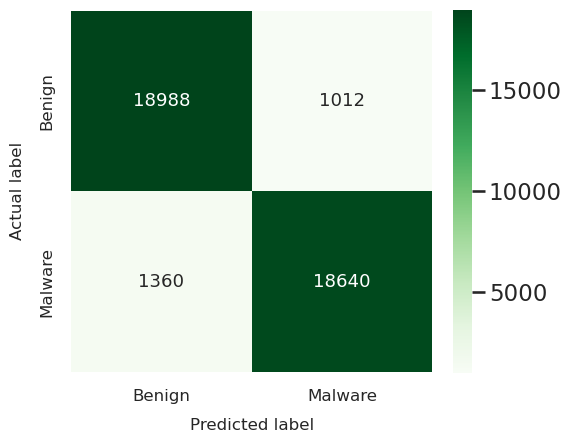

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


labels = ["Benign", "Malware"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)  # "talk" is a bit larger than "notebook"

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,       
    linecolor="white",  
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7, 
        "pad": 0.05,   
        "fraction": 0.1
    },
    annot_kws={"size": 13},

)  

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9833
AUC via roc_auc_score:           0.9833


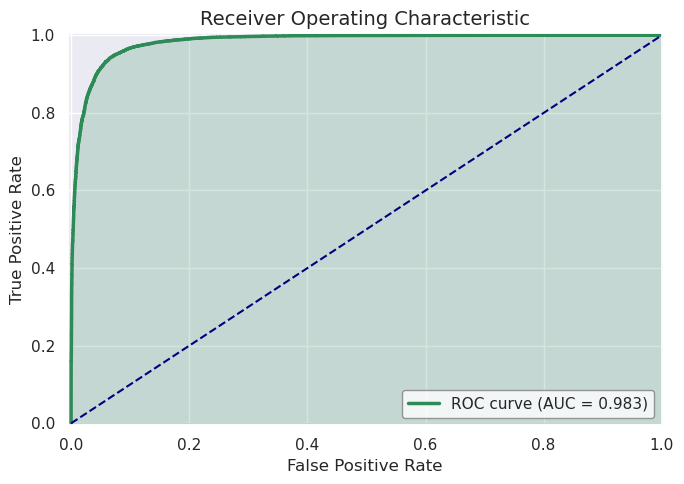

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


## Phishing

In [ ]:
DATA_CSV       = "../../datasets/phishing/phishing_preprocessed.csv"
CHECKPOINT     = "../models/domain/BEST_phish_distilbert-base-uncased_20250504_014049.pt" 
PRETRAINED     = "distilbert-base-uncased"
SPLITS_NPZ = "splits.npz"
MAX_LENGTH     = 32
BATCH_SIZE     = 512
RANDOM_STATE   = 42
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Subset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)

df = pd.read_csv(DATA_CSV, usecols=["domain_name", "label"])  # or however your loader works
domains = df["domain_name"]
labels  = df["label"]

splits = np.load(SPLITS_NPZ)
train_idx = splits["train"]
val_idx   = splits["val"]
test_idx  = splits["test"]

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)
full_dataset = DomainDataset(
    df,                      
    tokenizer,               
    MAX_LENGTH               
)

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
test_ds  = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)
state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels_batch   = batch["label"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits  = outputs.logits

        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels_batch.cpu().tolist())

        probs = torch.softmax(logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())

acc  = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)
fpr, tpr, _   = roc_curve(all_labels, all_probs)
roc_auc_score = roc_auc_score(all_labels, all_probs)

print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")
print(f"roc_auc:   {roc_auc_score:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


accuracy:  0.9407
precision: 0.9485
recall:    0.9320
f1-score:  0.9402
roc_auc:   0.9860


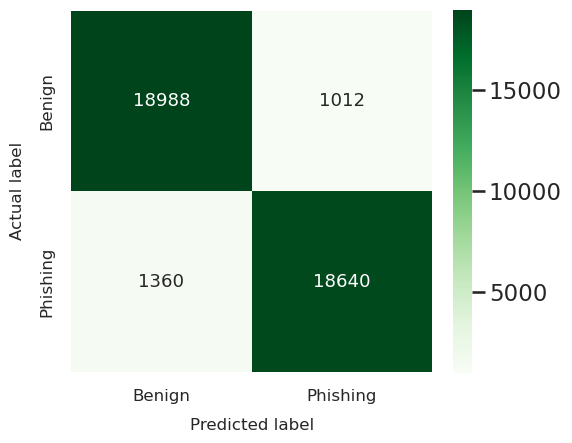

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Benign", "Phishing"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,       
    linecolor="white",  
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7,  
        "pad": 0.05,    
        "fraction": 0.1 
    },
    annot_kws={"size": 13},

)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)             
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9860
AUC via roc_auc_score:           0.9860


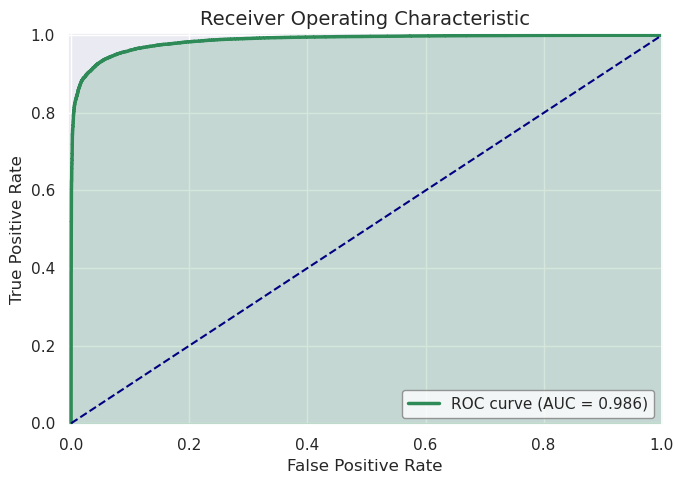

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


# RDAP

## Malware

In [ ]:
# 2. Config
DATA_CSV       = "../../datasets/malware/rdap_malware_preprocessed.csv"
CHECKPOINT     = "../models/rdap/malware_electra-base-discriminator_20250512_174759_BEST.pt" 
PRETRAINED     = "google/electra-base-discriminator"
MAX_LENGTH     = 230
BATCH_SIZE     = 16
VAL_SPLIT      = 0.20
RANDOM_STATE   = 42
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(DATA_CSV, usecols=["input_string", "label"])
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE,
)

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

val_dataset = RDAPDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)

state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []
total_loss = 0.0

with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        total_loss += outputs.loss.item()

        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

avg_val_loss = total_loss / len(val_loader)
acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)

print(f"val_loss:  {avg_val_loss:.6f}")
print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_loss:  0.100046
accuracy:  0.9650
precision: 0.9610
recall:    0.9552
f1-score:  0.9581


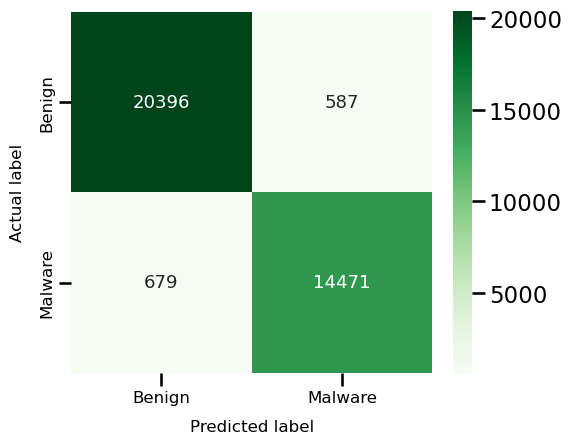

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Benign", "Malware"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,       
    linecolor="white",  
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7,  
        "pad": 0.05,    
        "fraction": 0.1 
    },
    annot_kws={"size": 13},

) 

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)             
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9931
AUC via roc_auc_score:           0.9931


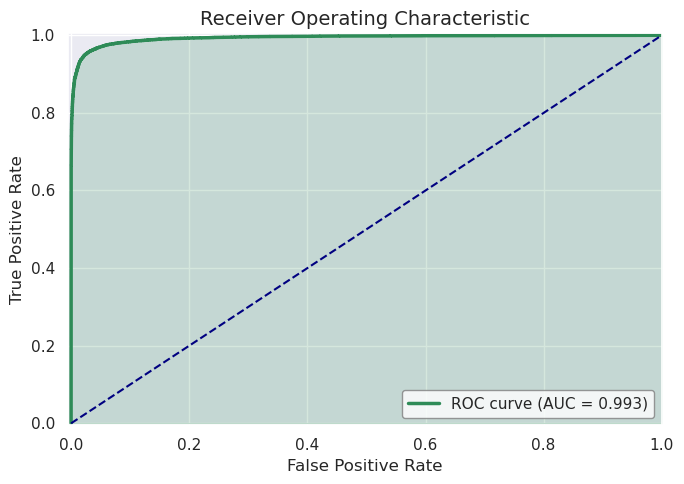

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


## Phishing

In [ ]:
DATA_CSV       = "../../datasets/phishing/rdap_phishing_preprocessed.csv"
CHECKPOINT     = "../models/rdap/phishing_distilbert-base-uncased_20250512_201957_BEST.pt" 
PRETRAINED     = "distilbert-base-uncased"
MAX_LENGTH     = 250
BATCH_SIZE     = 64
VAL_SPLIT      = 0.20
RANDOM_STATE   = 42
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(DATA_CSV, usecols=["input_string", "label"])
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE,
)

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

val_dataset = RDAPDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)

state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []
total_loss = 0.0

with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        total_loss += outputs.loss.item()

        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

avg_val_loss = total_loss / len(val_loader)
acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)

print(f"val_loss:  {avg_val_loss:.6f}")
print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_loss:  0.055861
accuracy:  0.9824
precision: 0.9927
recall:    0.9773
f1-score:  0.9849


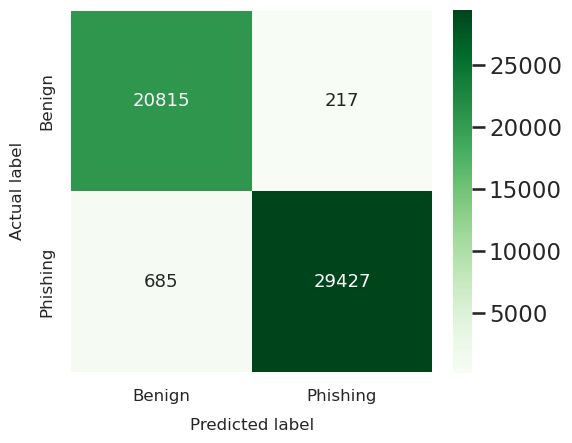

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


labels = ["Benign", "Phishing"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)  

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,     
    linecolor="white",
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7, 
        "pad": 0.05,   
        "fraction": 0.1
    },
    annot_kws={"size": 13},

)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9973
AUC via roc_auc_score:           0.9973


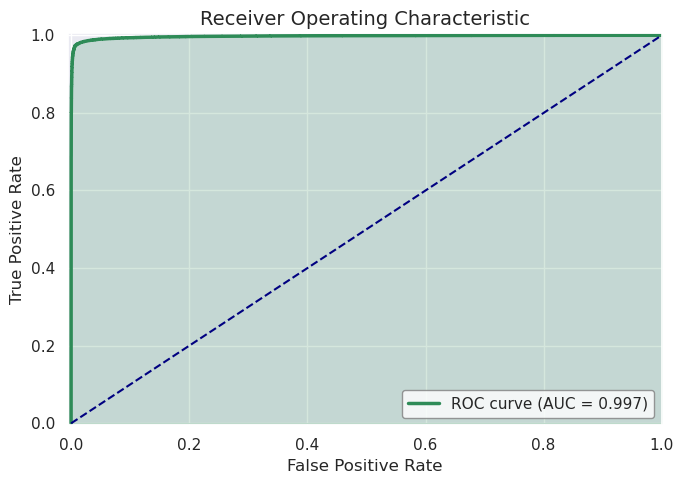

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


# DNS

## Malware

In [ ]:
DATA_CSV       = "../../datasets/malware/dns_malware_preprocessed.csv"
CHECKPOINT     = "../models/dns/malware_electra-base-discriminator_20250512_220139_BEST.pt" 
PRETRAINED     = "google/electra-base-discriminator"
MAX_LENGTH     = 150
BATCH_SIZE     = 32
VAL_SPLIT      = 0.20
RANDOM_STATE   = 42
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(DATA_CSV, usecols=["input_string", "label"])
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE,
)

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

val_dataset = RDAPDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)

state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []
total_loss = 0.0

with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        total_loss += outputs.loss.item()

        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

avg_val_loss = total_loss / len(val_loader)
acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)

print(f"val_loss:  {avg_val_loss:.6f}")
print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_loss:  0.118197
accuracy:  0.9604
precision: 0.9661
recall:    0.9532
f1-score:  0.9596


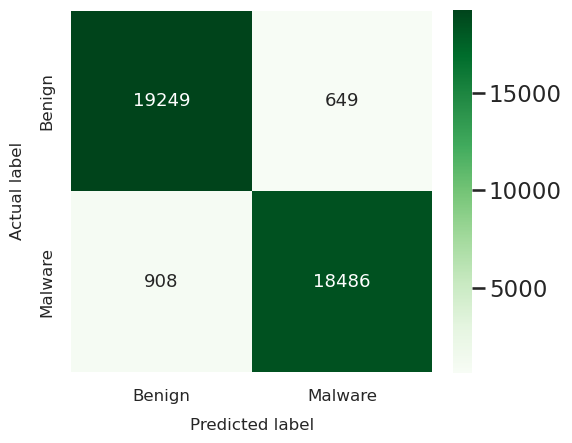

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


labels = ["Benign", "Malware"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)  

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,      
    linecolor="white", 
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7,  
        "pad": 0.05,    
        "fraction": 0.1 
    },
    annot_kws={"size": 13},

)  

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9924
AUC via roc_auc_score:           0.9924


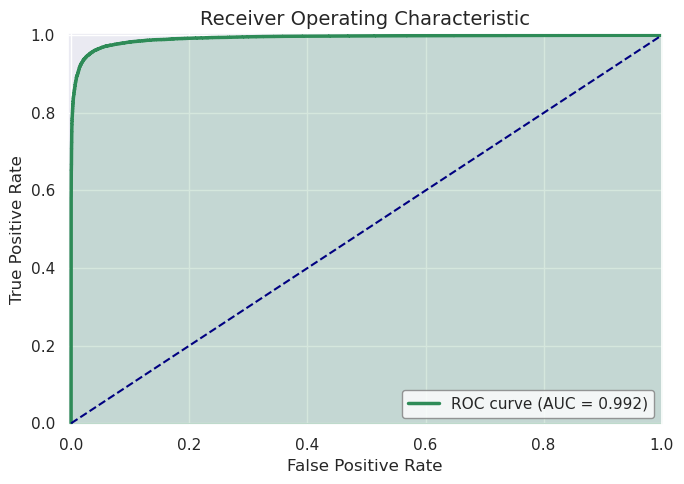

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


## Phishing

In [ ]:
DATA_CSV       = "../../datasets/phishing/dns_phishing_preprocessed.csv"
CHECKPOINT     = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt" 
PRETRAINED     = "distilbert-base-uncased"
MAX_LENGTH     = 150
BATCH_SIZE     = 128
VAL_SPLIT      = 0.20
RANDOM_STATE   = 42
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(DATA_CSV, usecols=["input_string", "label"])
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE,
)


tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

val_dataset = RDAPDataset(
    dataframe=val_df,        
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)

state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []
total_loss = 0.0

with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        total_loss += outputs.loss.item()

        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

avg_val_loss = total_loss / len(val_loader)
acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)

print(f"val_loss:  {avg_val_loss:.6f}")
print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_loss:  0.070223
accuracy:  0.9795
precision: 0.9834
recall:    0.9755
f1-score:  0.9794


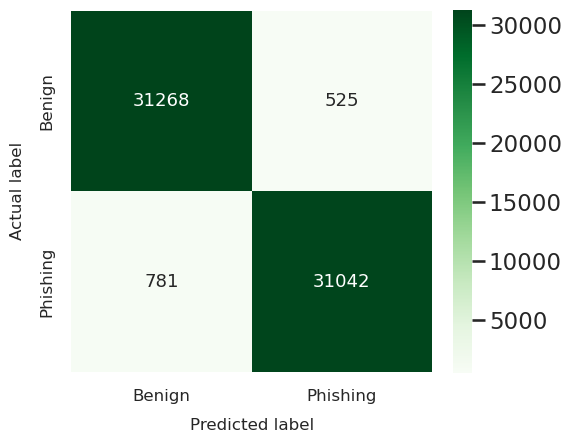

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Benign", "Phishing"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)  

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,     
    linecolor="white",
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7, 
        "pad": 0.05,   
        "fraction": 0.1
    },
    annot_kws={"size": 13},

)  

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9963
AUC via roc_auc_score:           0.9963


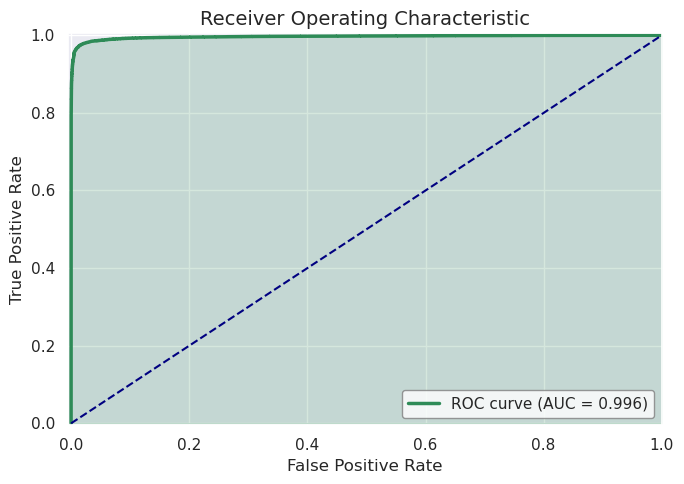

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


# GEO

## Malware

In [ ]:
DATA_CSV       = "../../datasets/malware/geo_malware_preprocessed.csv"
CHECKPOINT     = "../models/geo/malware_electra-base-discriminator_20250513_010704_BEST.pt" 
PRETRAINED     = "google/electra-base-discriminator"
MAX_LENGTH     = 50
BATCH_SIZE     = 128
VAL_SPLIT      = 0.20
RANDOM_STATE   = 42 
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(DATA_CSV, usecols=["input_string", "label"])
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE,
)

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

val_dataset = RDAPDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)

state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []
total_loss = 0.0

with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        total_loss += outputs.loss.item()

        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

avg_val_loss = total_loss / len(val_loader)
acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)

print(f"val_loss:  {avg_val_loss:.6f}")
print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_loss:  0.116031
accuracy:  0.9568
precision: 0.9503
recall:    0.9644
f1-score:  0.9573


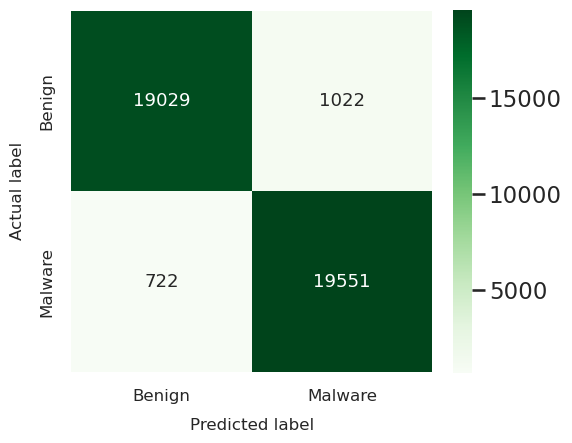

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Benign", "Malware"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,     
    linecolor="white",
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7, 
        "pad": 0.05,   
        "fraction": 0.1
    },
    annot_kws={"size": 13},

)  

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9917
AUC via roc_auc_score:           0.9917


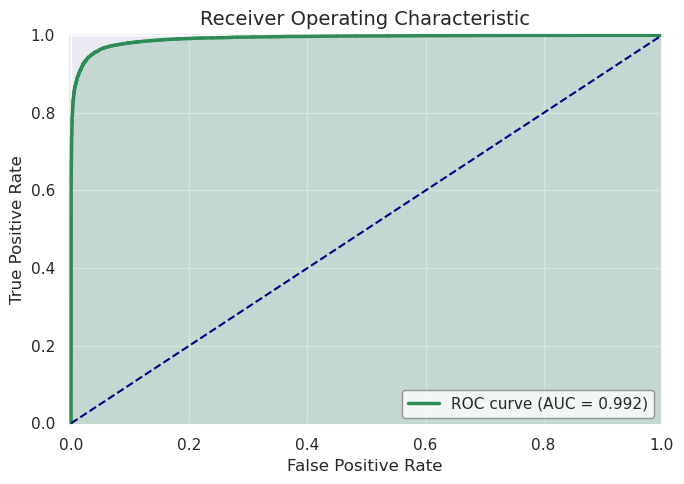

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()


## Phishing

In [ ]:
DATA_CSV       = "../../datasets/phishing/geo_phishing_preprocessed.csv"
CHECKPOINT     = "../models/geo/phishing_distilbert-base-uncased_20250513_013233_BEST.pt" 
PRETRAINED     = "distilbert-base-uncased"
MAX_LENGTH     = 64
BATCH_SIZE     = 256
VAL_SPLIT      = 0.20
RANDOM_STATE   = 42  
NUM_LABELS     = 2
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv(DATA_CSV, usecols=["input_string", "label"])
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SPLIT,
    random_state=RANDOM_STATE,
)
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

val_dataset = RDAPDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED,
    num_labels=NUM_LABELS
).to(DEVICE)

state_dict = torch.load(CHECKPOINT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []
total_loss = 0.0

with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        total_loss += outputs.loss.item()

        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

avg_val_loss = total_loss / len(val_loader)
acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)

print(f"val_loss:  {avg_val_loss:.6f}")
print(f"accuracy:  {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"recall:    {rec:.4f}")
print(f"f1-score:  {f1:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_loss:  0.063796
accuracy:  0.9789
precision: 0.9838
recall:    0.9738
f1-score:  0.9788


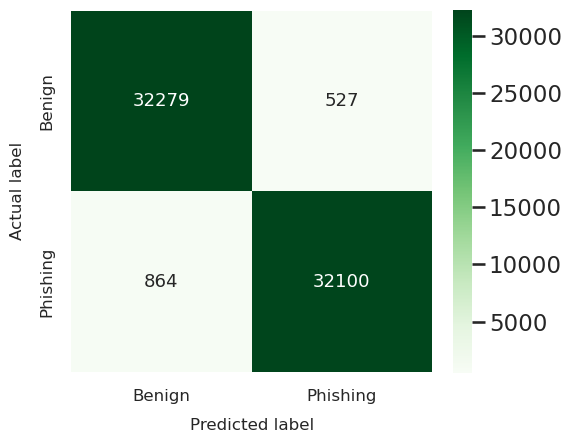

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Benign", "Phishing"]
cm = confusion_matrix(all_labels, all_preds)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk", font_scale=1)

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    linewidths=0,      
    linecolor="white", 
    square=True,
    ax=ax,
    cbar_kws={
        "shrink": 0.7, 
        "pad": 0.05,   
        "fraction": 0.1
    },
    annot_kws={"size": 13},

)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("Predicted label", fontsize=12, labelpad=10)
ax.set_ylabel("Actual label",  fontsize=12, labelpad=10)
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_yticklabels(labels, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, auc

all_probs, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        probs = F.softmax(outputs.logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = roc_auc_score(all_labels, all_probs)

print(f"AUC via auc(fpr, tpr):           {roc_auc1:.4f}")
print(f"AUC via roc_auc_score:           {roc_auc2:.4f}")


AUC via auc(fpr, tpr):           0.9965
AUC via roc_auc_score:           0.9965


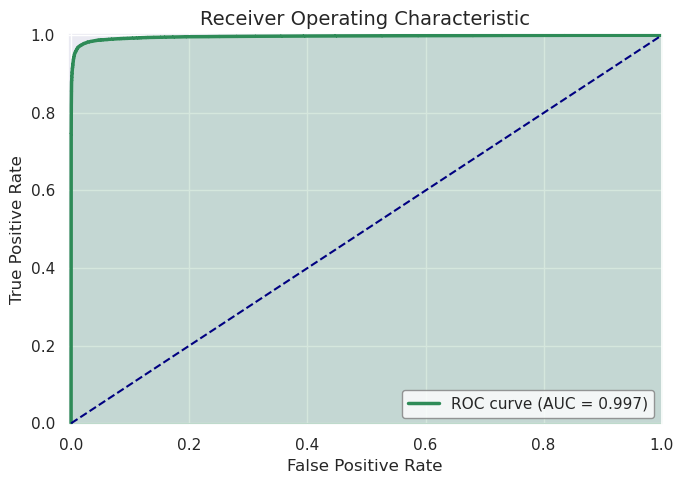

In [ ]:

import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(7, 5))

ax.fill_between(fpr, tpr, color="seagreen", alpha=0.2)

ax.plot(fpr, tpr,
        color="seagreen", lw=2.5,
        label=f"ROC curve (AUC = {roc_auc2:.3f})")
ax.plot([0, 1], [0, 1],
        color="navy", lw=1.5, linestyle="--",
        )

ax.set_xlim(left=-0.005, right=1)
ax.set_ylim(bottom=-0.005, top=1.005)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("Receiver Operating Characteristic", fontsize=14)
ax.legend(loc="lower right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.show()
